In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 405.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all th

In [ ]:
#!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

In [ ]:
#!pip install torchdata==0.6.0

In [ ]:
#!pip install torchtext==0.15.1

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import numpy as np

In [ ]:
torch.__version__

'1.13.1+cu117'

In [ ]:
class BinaryClassification(nn.Module):
  def __init__(self, embed_size, device):
    super(BinaryClassification, self).__init__()
    # Number of input features is embed_size.
    self.layer_1 = nn.Linear(embed_size, 64)
    self.layer_2 = nn.Linear(64, 64)
    self.layer_out = nn.Linear(64, 1)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.device = device

  def forward(self, inputs, src):
    x = self.relu(self.layer_1(inputs))
    x = self.batchnorm1(x)
    x = self.relu(self.layer_2(x))
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.layer_out(x)
    #if math.isnan (x[0][0]):
    #  print(src)

    return x

In [ ]:
class Classifier(nn.Module):
  def __init__(self, d_model, seq_len, nhead, dim_feedforward, nlayers, device, dropout = 0.5):
    super(Classifier, self).__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.nhead = nhead
    self.dim_feedforward = dim_feedforward
    self.nlayers = nlayers
    self.device = device
    #self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.position_embedding = nn.Embedding(seq_len, d_model)
    encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
    self.encoder = TransformerEncoder(encoder_layer, nlayers)
    self.binary_classifier = BinaryClassification(seq_len*d_model, device)


  def forward(self, src: Tensor) -> Tensor:
    #print("Classifier forwrd")
    """
    Args:
        src: Tensor, shape [seq_len, batch_size]
        src_mask: Tensor, shape [seq_len, seq_len]
    Returns:
        output Tensor of shape [seq_len, batch_size, ntoken]
    """
    N, seq_length, embed_size = src.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    #print(f"src before positional embeddings: {src.shape}")
    src_ = src + self.position_embedding(positions)
    #print(f"src after positional embeddings: {src_.shape}")
    #print(f"src after positional embeddings: {src.shape}")
    #print(src)
    #print("before encoder")
    output = self.encoder(src_)
    #print(f"encoder output shape: {output.shape}")
    #print(output[0])
    #print(output)
    #print("after encoder")
    output = self.binary_classifier(torch.reshape(output, (N, seq_length*embed_size)), src) ##
    return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#hyperparameters
dim_feedforward=16
#dim_feedforward=32
nlayers_tx=8

In [ ]:
model = Classifier(d_model=7, seq_len=108, nhead=7, dim_feedforward=8, nlayers=8, device=device)
model.to(device)

Classifier(
  (position_embedding): Embedding(108, 7)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=8, out_features=7, bias=True)
        (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dro

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/FYP_Data/Ablation

/content/drive/My Drive/FYP_Data/Ablation


In [ ]:
x = np.load("Ablation_Data.npy")
y = np.load("Ablation_Labels.npy")

In [ ]:
print(x.shape)
print(y.shape)

(24269, 108, 7)
(24269,)


In [ ]:
X, X_test, Y, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #test split

In [ ]:
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

In [ ]:
#load test
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42) #validation split

In [ ]:
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_val.npy",X_val)
np.save("y_val.npy",y_val)

In [ ]:
#load train val
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_val = np.load("X_val.npy", allow_pickle=True)
y_val = np.load("y_val.npy", allow_pickle=True)

In [ ]:
print(X_train.shape)

(19656, 108, 7)


In [ ]:
X_train = X_train[:19656]

In [ ]:
print(X_val.shape)

(2184, 108, 7)


In [ ]:
X_val = X_val[:2184]

In [ ]:
print(X_test.shape)

(2427, 108, 7)


In [ ]:
print(np.sum(y_train)/y_train.shape[0])
print(np.sum(y_val)/y_val.shape[0])
print(np.sum(y_test)/y_test.shape[0])

0.02574146614437605
0.02425629290617849
0.02843016069221261


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
## train data
from sklearn import preprocessing
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(X_train, y_train)

## val data
class ValData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


val_data = ValData(X_val, y_val)

## test data
class TestData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


test_data = TestData(X_test, y_test)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch.float())
        #y_pred = (y_pred>0.5).float()
        #print(f"y_pred = {y_pred}")
        #print(f"y_batch.unsqueeze(1) = {y_batch.unsqueeze(1)}")

        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    val_loss = 0
    val_accuracy = 0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch.float())
        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())
        val_loss += loss.item()
        val_accuracy += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val_Loss: {val_loss/len(test_loader):.5f} | Val_Acc: {val_accuracy/len(test_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.09293 | Acc: 96.980 | Val_Loss: 0.03083 | Val_Acc: 99.588
Epoch 002: | Loss: 0.03521 | Acc: 99.231 | Val_Loss: 0.03296 | Val_Acc: 99.464
Epoch 003: | Loss: 0.03005 | Acc: 99.298 | Val_Loss: 0.02537 | Val_Acc: 99.629
Epoch 004: | Loss: 0.02759 | Acc: 99.377 | Val_Loss: 0.54930 | Val_Acc: 99.341
Epoch 005: | Loss: 0.02735 | Acc: 99.413 | Val_Loss: 0.09531 | Val_Acc: 99.094
Epoch 006: | Loss: 0.02531 | Acc: 99.432 | Val_Loss: 0.03039 | Val_Acc: 99.588
Epoch 007: | Loss: 0.02824 | Acc: 99.324 | Val_Loss: 0.02821 | Val_Acc: 99.547
Epoch 008: | Loss: 0.02813 | Acc: 99.302 | Val_Loss: 0.20122 | Val_Acc: 99.341
Epoch 009: | Loss: 0.02820 | Acc: 99.336 | Val_Loss: 0.04140 | Val_Acc: 99.300
Epoch 010: | Loss: 0.02850 | Acc: 99.349 | Val_Loss: 0.04490 | Val_Acc: 99.258


In [ ]:
#PATH = './DeFi_Supervised_v1.pth'
#PATH = './DeFi_Ablation_v2.pth'
PATH = './DeFi_Ablation_v3.pth'
#torch.save(model, PATH)

In [ ]:
#PATH = './DeFi_Ablation_v1.pth'
#PATH = './DeFi_Ablation_v2.pth'
PATH = './DeFi_Ablation_v3.pth'
loaded_model = torch.load(PATH)
loaded_model.eval()

Classifier(
  (position_embedding): Embedding(108, 7)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=8, out_features=7, bias=True)
        (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dro

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
y_pred = []
y_true = []
sigmoid = nn.Sigmoid()

for X_batch, y_batch in test_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = torch.round(sigmoid(loaded_model(X_batch.float())))
        y_pred.extend(y_batch_pred.cpu().detach().numpy())
        y_true.extend(y_batch.cpu().detach().numpy())

In [ ]:
count_true = 0
for i in range(len(y_pred)):
  if y_true[i]==y_pred[i]:
    count_true+=1
acc = count_true/len(y_pred)
print(len(y_test))
print(acc)

2427
0.992583436341162


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(2354, 4, 14, 55)

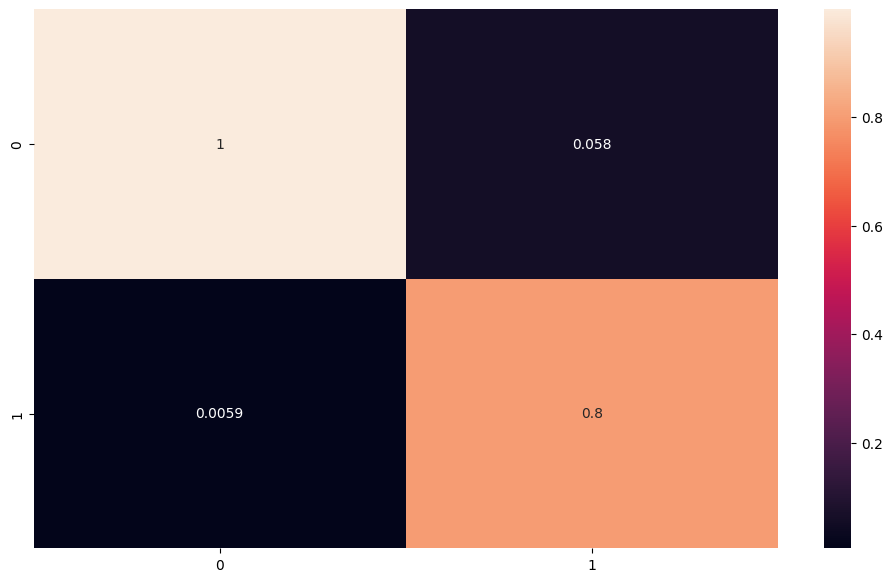

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = ['0','1'],
                     columns = ['0','1'])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

**Two token**

In [ ]:
#Anubis
ankh_x1 = np.load("ankh_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.2284]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9375]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#full

#for i in range(50,108):
#  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[7.5255e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi
sushi_x1 = np.load("sushi_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0580]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9919]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9957]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Full

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

**APE**

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving ape_full_x1.npy to ape_full_x1.npy


In [ ]:
#Ape
x1 = np.load("ape_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0006]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9763]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9997]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Full

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[8.2050e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)